## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [18]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


----
### 1- Summarization

1.1- Number of records in the dataset.

In [19]:
#data.shape
data.shape[0]

45222

1.2- Col Names / Data types of the features and target columns / non-null values and memory usage.

In [20]:
#data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


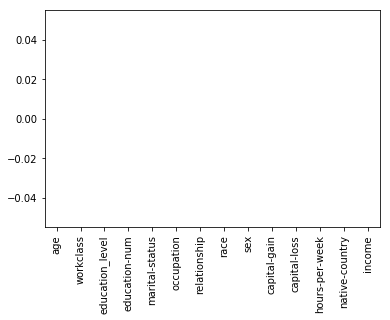

In [21]:
(data.isna().sum()/data.shape[0]).plot(kind='bar')

1.3- Descriptive statistics. For both numeric (summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values) and categorical columns (count, unique, frequenct, top).

In [22]:
data.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
# for age, education-num, hours-per-week : use [.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]
# for capital-gain, capital-loss: use [.9, .91, .92, .93, .94, .95, .96, .97, .98, .99]

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
5%,20.000000,6.000000,0.000000,0.000000,20.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
95%,62.000000,14.000000,5013.000000,0.000000,60.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [23]:
data.describe(include=['object'])
#data.describe(include=['O'])

,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country,income
count,45222,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,33307,14783,21055,6020,18666,38903,30527,41292,34014


>**Summarization conclusions:**
- There are 14 columns in the dataset, 1 for the target variable(income) and 13 predictor variables.
- There are 8 categorical variables and 5 numerical variables (4 in floating format and 1 in integer format).
- The dataframe is pretty much clean regarding the existence of null values, no imputation is required so far.
___

----
### 2- Univariate Analysis

In [24]:
#helper function to display percentage on bar plot mainly for categorical variables
def plot_univar_percentage(dataframe, colname, figsize_X=4, figsize_Y=3):
    sns.set(style="darkgrid")
    plt.figure(figsize=(figsize_X,figsize_Y))
    all_counts = float(dataframe.shape[0])
    colname_count_plot = sns.countplot(x=colname,data=dataframe)
    plt.title((colname.capitalize() + " Stats.") , fontsize=13)
    for p in colname_count_plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/all_counts)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        colname_count_plot.annotate(percentage, (x, y),ha='center')
    plt.show()

2.1- Target Variable (income).

In [25]:
#data['income'].unique()
data['income'].value_counts()
#data['income'].value_counts(normalize=True)

<=50K    34014
>50K     11208
Name: income, dtype: int64

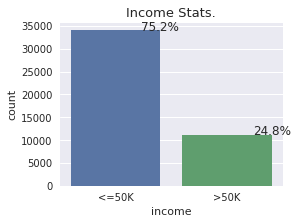

In [26]:
#data.iloc[:,-1].hist(bins=2)
#data['income'].value_counts().plot(kind="bar")
#inc_count_plot = sns.countplot(x="income",data=data)
plot_univar_percentage(data, "income")

Cat.<br>
2.2- Gender.<br>
2.3- education_level.<br>
2.4- workclass<br>
2.5- marital-status<br>
2.6- occupation<br>
2.7- relationship<br>
2.8- race<br>
2.9- native-country<br>
Numer.<br>
2.10- age<br>
2.11- education-num<br>
2.12- capital-gain<br>
2.13- capital-loss<br>
2.14- hours-per-week<br>

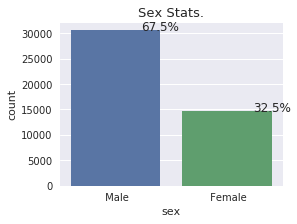

In [27]:
plot_univar_percentage(data, "sex")
#plot_univar_percentage(data, "education_level", figsize_X=15, figsize_Y=12)
#plot_univar_percentage(data, "workclass", figsize_X=9, figsize_Y=6)
#plot_univar_percentage(data, "marital-status", figsize_X=13, figsize_Y=10)
#plot_univar_percentage(data, "occupation", figsize_X=17, figsize_Y=14)
#plot_univar_percentage(data, "relationship", figsize_X=17, figsize_Y=14)
#plot_univar_percentage(data, "race", figsize_X=9, figsize_Y=6)
#plot_univar_percentage(data, "native-country", figsize_X=21, figsize_Y=18)

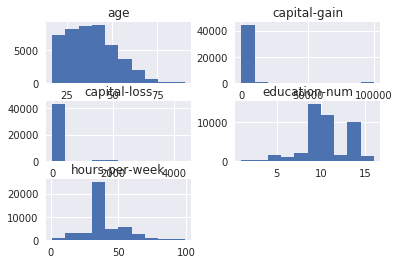

In [28]:
"""for column in data.select_dtypes('number').columns:
    plt.figure(figsize=(5,2))
    sns.distplot(data[column])"""

data.hist()
plt.show()

**Univariate Analysis conclusions:**
>**distribution of categorical features:**
- For the Target Variable (income), it has only two value ("<=50K", ">50K"), with 75.2% (34014) of the individuals having income less than or equal to 50K, and 24.8% (11208) having income greater than 50K.  
- For Gender, 67.5% of the individuals are Males, while onle 32.5% are Females.
- For (education_level), there are 16 values in this category, among them the (HS-grad, Some-college, Bachelors) representing the largest with (32.7%, 21.9%, 16.7%) respectively.
- For (workclass), there are 7 unique values, with (Private) alone representing 73.7% of the total.
- For (marital-status), there are 7 unique values, with "Married-civ-spouse" (46.6%), "Never-married" (32.3%), and "Divorced" (13.9%) representing the top 3 values.
- For (occupation), there are 14 unique values, all values has their own contribution to the total number, with exception to the "Arme-Force"(0.0%).
- For (relationship), there are 6 unique values, with "Husband" (41.3%), "Not-in-family" (25.9%) representing the top 2 values.
- For (race), there are 5 unique values, with "White" representing the majority with 86.0%.
- For (native-country), there are 41 different countries, however, the "United-states" representing has the majority with 91.3%.

 >**distribution of numerical feature values:** 
- For (age), 50% of the individuals are aged between 17 and 38, and almost 90% are below 57 years old.
- For (education-num), almost 70% have completed less than 11 educational years.
- For (capital-gain), almost 90% have less than 0.00 capital-gain.
- For (capital-loss), 95% have less than 0.00 capital-loss.
- For (hours-per-week), 70% work for less than 42 hours-per-week, and almost 90% work for less than 55 hours-per-week.
___

----
### 3- Bivariate analysis
Numerical & Categorical Variables<br>
...<br>
Categorical & Categorical Variables<br>
 ...<br>
 ___

----
### 4- Multivariate Analysis
<br>
___

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [29]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = (data["income"][data["income"] == ">50K"]).count()

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = (data["income"][data["income"] == "<=50K"]).count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = ((data["income"][data["income"] == ">50K"]).count())/data.shape[0]

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.2478439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

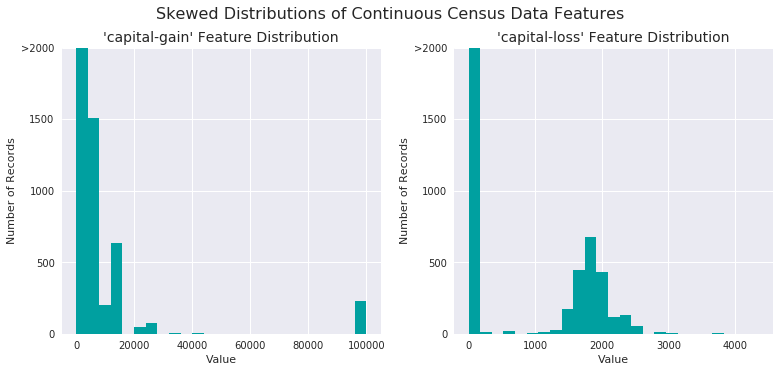

In [30]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

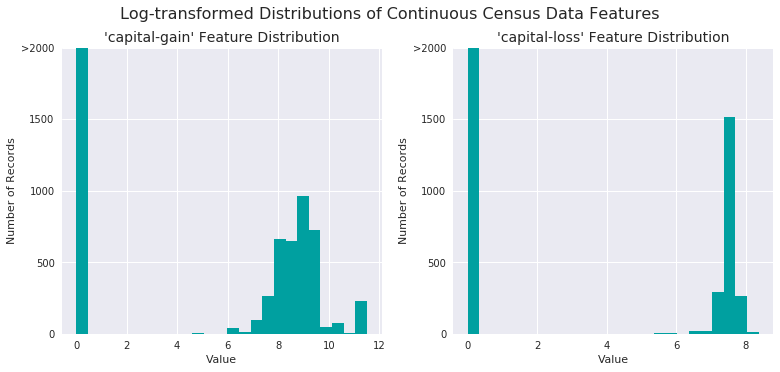

In [31]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [32]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [33]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
#cat_columns = ["sex", "education_level", "workclass", "marital-status", "occupation", "relationship", "race", "native-country"]
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x : 1 if x == ">50K" else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [34]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [35]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
TP = np.sum(income) # Counting TRUE ones in income_raw
FP = income.count() - TP # missclassified cases-negatives predicted as positive
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

#Acc = TP+TN/P+N
accuracy = (TP+TN) / (TP+TN+FP+FN)
#Rec= TP/TP+FN
recall = TP/(TP + FN)
#Prec= TP/TP+FP
precision = TP/(TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))
# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


**Answer: **
* Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **<br>

-Obviously, we are dealing with a **Binary Classification** problem since in this classification task we have two class labels (a person with income more than \\$50,000) and (a person with income less than or equal to \\$50,000) or (0 and 1) in our encoded target variable.<br>
-To be more accurate, it is in fact an *Imbalanced Classification* task, as the number of examples in each class is unequally distributed (in the dataset, the number of persons with income less than or equal to \\$50,000 is almost three times larger compared to those with income more than \\$50,000). Some more specialized algorithms may be more effective in this case such as cost-sensitive machine learning algorithms(e.g., Cost-sensitive Support Vector Machines).<br>
-I chose to try the following three models:- Gaussian Naive Bayes, AdaBoost, and Support Vector Machines for the reasons discussed below:-<br>

##### Gaussian Naive Bayes
- Describe one real-world application in industry where the model can be applied.<br>
Besides being one of the earliest and most popular methods for spam siltering, Gaussian Naive Bayes and Naive Bayes in general can be and has already been used in Health care insudtry such as Computer Aided Diagnostics (CAD) (e.g., Cancer Classification, predict heart disease) \[[1](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 1"), [2](https://ieeexplore.ieee.org/abstract/document/8950650/authors#authors "Ref. 2")\].
- What are the strengths of the model; when does it perform well?<br>
It can be used for both binary and multi-class categories, in addition robustness, simplicity, speed of the execution, and the accuracy are some of the defining characteristics of the Naive Bayes algorithm. The algorithm is also robust to noise features, and can work with a small amount of data \[[1](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 1"), [3](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 3")\].
- What are the weaknesses of the model; when does it perform poorly?<br>
The Naive Bayes algorithm has strong assumptions on features independence, and deterioration in performance may occur when such assumption is violated, which is a typical case with most real-world datasets as they tend to not have independent features. However, some procedures like preselection of features where correlated features are eliminated may help in minimizing the effects of the problem.\[[1](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 1"), [3](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 3")\].
- What makes this model a good candidate for the problem, given what you know about the data?<br>
After the data preparation phase and the feature transformation our dataset ended up with 103 features and 1 target feature also the training data contains approximately 35000 samples, thus, the Naive Bayes is a good candidate as it could represent a fast and effecient model that is able to deal with a dataset of large amount of features, and as mentioned earlier, the algorithm can deal with noisy features, and can work with a small amount of data.

<br>

##### AdaBoost
- Describe one real-world application in industry where the model can be applied.<br>
Adaboost is basically an ensemble learning process “meta-learning” that gained popularity in the last five years, and now it is being used to classify more complex classification problems other than binary classification ones such as text categorization, image classification and Face Detection, and Computer Aided Diagnostics (CAD) \[[4](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-01201-2 "Ref. 4"), [5](https://www.researchgate.net/publication/321583409_AdaBoost_typical_Algorithm_and_its_application_research "Ref. 5")\].
- What are the strengths of the model; when does it perform well?<br>
Robustness and efficiency are the two main characteristics of the AdaBoost method which made it one of the most widely applied methods to data classification and object detection. AdaBoost has good generalization capability, fast performance and low computational complexity, as well as low implementation complexity\[[6](https://www.hindawi.com/journals/jece/2015/835357/ "Ref. 6"), [7](https://www.researchgate.net/publication/239542136_'Modest_AdaBoost'_-_Teaching_AdaBoost_to_Generalize_Better "Ref. 7")\].
- What are the weaknesses of the model; when does it perform poorly?<br>
It is reported in various case studies that being sensitive to noisy data and outliers is one of the major problems of the Adaptive Boosting model as it needs a quality dataset, also the need for a large sample can represent a major concern\[[1](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 1"), [8](https://ieeexplore.ieee.org/abstract/document/8934236 "Ref. 8")\].
- What makes this model a good candidate for the problem, given what you know about the data?<br>
The AdaBoost is very fast, and the effeciency of an algorithm or a model has been always a concern. Also, since The Adaboost has demonstrated better performance in precision in many case studies, and since lowering the False-Positive in our model  is a requirement (the desired model should be abile to precisely predict those that make more than 50,000 is more important than the model's ability to recall those individuals), the AdaBoost method is chosen.
<br>

##### Support Vector Machines
- Describe one real-world application in industry where the model can be applied.<br>
SVMs have been used to solve many real-world problems in various application domains. SVMs can be used for cancer classification in Bioinformatics, and for classification of credit card fraud in financial section. SWMs have been used in other sreas such as Face detection, text categorization, image classification \[[9](https://www.researchgate.net/publication/341270113_A_comprehensive_survey_on_support_vector_machine_classification_Applications_challenges_and_trends "Ref. 9")\].
- What are the strengths of the model; when does it perform well?<br>
One of the major advantages of SVMs is that it scales relatively well to high dimensional data. Also, SVM models has some lower risk of over-fitting and have good generalization\[[9](https://www.researchgate.net/publication/341270113_A_comprehensive_survey_on_support_vector_machine_classification_Applications_challenges_and_trends "Ref. 9")\].
- What are the weaknesses of the model; when does it perform poorly?<br>
The excessive computational cost due to the algorithmic complexity, is the major drawback when using SWMs, especially when dealing with large datasets. SWMs tends to have problems when dealing with imbalanced data, and SWMs have some difficulties in correctly classifying minority class objects in these skewed datasets. Also, it is not a straightforward task to fine-tune the hyperparameters(C and gamma) or have a good grasp on or visualize their impact \[[1](https://link.springer.com/article/10.1007/s00500-020-05297-6 "Ref. 1"), [9](https://www.researchgate.net/publication/341270113_A_comprehensive_survey_on_support_vector_machine_classification_Applications_challenges_and_trends "Ref. 9")\].
- What makes this model a good candidate for the problem, given what you know about the data?<br>
The main reason behind choosing this model is aiming for a model that can avoid overfitting the data at hand.



### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [36]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


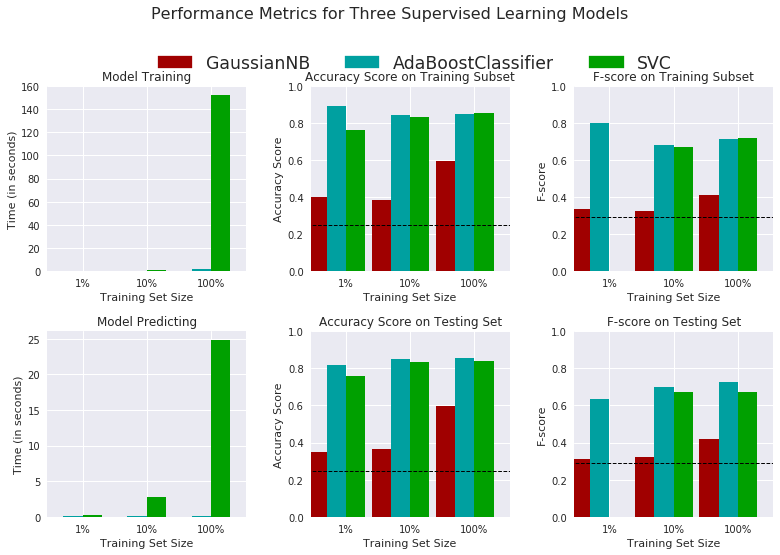

In [37]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=33)
clf_C = SVC(random_state=33)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = X_train.shape[0]
samples_10 = samples_100 // 10
samples_1 = samples_100 // 100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

- For the given situation (the requirements, the nature of the dataset) and also given the results of our initial model evaluation, the AdaBoost represents the most effecient and effective method to tackle our classification problem for the reasons given below:-
    - In both cases (Model training, and Model prediction) and for the entire dataset given (100% of the training set), two out of the three chosen models (AdaBoostClassifier, SVC) have good accuracy and stable scores (no big variation observed in scores obtained in predictions on both training and testing data, indicating a low bias and low variance). The same can be observed regarding the F-score, good scores with little variability for both the (AdaBoostClassifier, SVC).
    - Keeping in mind that according to the requirements in the CharityML model more emphasis on a more precise model is desired (a good model in this case should minimize the FP in the results "i.e., find individuals willing to donate"). Despite (SVC) managed to obtain a "slightly" better F-score than that for the (AdaBoostClassifier) on the training data, however the (AdaBoostClassifier) still managed to obtain the best F-score regarding the testing data.
    - Finally, the (AdaBoostClassifier) proved to be a much faster model compared to the (SVC). Accordingly, for these two reasons (the speed of training and prediction and the quality of the results regarding the F-score), I recommend the AdaBoost for the CharityML, as a fast model which also can give precision some higher priority (the model has the ability to precisely predict those that make more than 50,000, which in our case is more important than the ability to recall those individuals.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

- AdaBoost is short for Adaptive Boosting, it is an ensemble learning technique “meta-learning” used in Machine Learning to find the best model. Adaboost is an ensemble sequential learner, where the succeeding models learn from the errors of the prior models. In other words, AdaBoost uses an iterative approach to learn from the mistakes of weak classifiers (ones that performs better than random guessing, but still performs poorly at designating classes to objects), and turn them into strong ones. AdaBoost is adaptive in that it tweaks subsequent weak learners in favor of those instances misclassified by previous classifiers. Generally speaking, Boosting (an Ensemble Method to Decrease Bias error which arises when models are not able to identify relevant trends in the data) is where algorithms tries to build a strong predictive model from the mistakes of several weaker models. For instance, in our case a weak model tries to roughly discover those individuals making more than 50,000, any misclassified point is heavily weighted and more focus will be given to those hard-to-classify individuals in an effort to appropriately classify them in subsequent iterations. Models are sequentially added with each one correcting its predecessor up until the training data is perfectly predicted or the maximum number of models has been reached.

- An analogy to the strategy adopted by AdaBoost is as follows: A human being who learns from mistakes and experiences. When one makes mistakes, one learns from them. A person keeps getting feedback from the community around him (family, friends, or supervisors). In every new experience, the person gets some advice or sometimes gets punished for serious mistakes. In this metaphor, here the person is a weak model who has very little or experience. The feedback the person is getting represents the loss function whose main purpose is to improve the performance of the weak model. At each new iteration, different parameters -as advice or experience- help build a more robust model that is more suitable to the dataset.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [38]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=33)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'learning_rate': [1.0, 1.5, 3.0], 'n_estimators':[50,100,300], 'algorithm': ['SAMME', 'SAMME.R']}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:581: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:166: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/opt/conda/lib/python3.6/site-packages/skle

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8666
Final F-score on the testing data: 0.7432


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model | Naive Predictor |
| :------------: | :---------------: | :-------------: | :-------------: |
| Accuracy Score |        0.8576     |   0.8666        |     0.2478      |
| F-score        |         0.7246    |   0.7432        | 0.2917          |


**Answer: **

- The Optimized Model scored 0.8666 on accuracy compared to an accuracy of 0.8576 for the Unoptimized Model. Regarding the F-score, the Optimized Model has F-score of 0.7432, while the Unoptimized Model scored 0.7246 on this metric.
- The Accuracy and the F-score of the Optimized Model are slightly better than those of the Unoptimized Model.
- Both the optimized and unoptimized models have significantly better accuracy and F-score of the naive predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**



- 1- education-num > The number of years a person invest in his education can be correlated with salary and income"The higher the level of education the higher the possibility to get a higher-paid job", also individuals with higher education are more likely to understand the cause of charity.<br>
- 2- hours-per-week > Same as above, with more working hours a higher salary is more likely (considering the same job at least).<br>
- 3- age > Older people have more stable financial situations, also more experiended individuals are paid more.<br>
- 4- capital gain > The more the person is financially stable, the more likely he may be willing to donate. On the other hand, any sign of financial instability signifies that the person is not in perfect condition to donate.<br>
- 5- workclass > The workclass can be an indication of the total income somehow. For instance, people who work in private sectors or those who have their own businesses tend to gain more than those who work for the government and state agencies.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

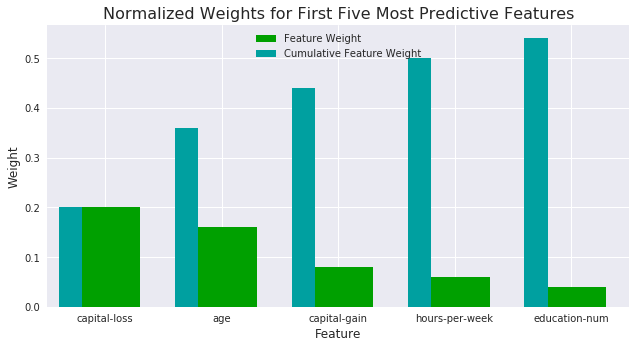

In [39]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=33).fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

- Based on the results of the Feature Importance Extraction in the above visualization, I can claim that I was able to correctly guess four out of those five visualized.
- In addition, the priorities for features in my guess are pretty much identical as that in the visualization (just swaping the age and the capital-gain).
- My intuition that education-num, and hours-per-week "in this order" is consistent with the visualized results.
- Moreover, as illustrated in the visualization, the capital_gain has a higher priority than age.
- However, the result as demonstrated in the visualization indicates that my guess for the workclass as an important feature was not accurate, or let's say, didn't have the high priority anticipated from my side.
- Finally, and for the fifth feature in the visulization, I can claim that it was still in my consideration revied no. 4 in answer to question 6 "On the other hand, any sign of financial instability signifies that the person is not in perfect condition to donate."

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [40]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8666
F-score on testing data: 0.7432

Final Model trained on reduced data
------
Accuracy on testing data: 0.8402
F-score on testing data: 0.6960


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**


|     Metric     | Final Model trained on reduced data | Final Model trained on full data |
| :------------: | :---------------------------------: | :------------------------------: |
| Accuracy Score |               0.8402                |                 0.8666           |
| F-score        |               0.6960                |                 0.7432           |


- Some slight deterioration in performance can be observed, the accuracy score and the F-score did decreased "not drastic though", despite the fact that we used only 5 features out of the 13 originally available in the dataset.

- In our specific case study, yes I would consider using the reduced data as the training set if the training time was a factor, using less than half of the features (5 out of 13) will definitely decrease the computational complexity and improve time, especially given that the decrease in metrics scores was not drastic.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [41]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 814205 bytes to finding_donors.html']